**<h1 align="center">Data Analysis Notebook</h1>**

<p align="center"><i>Analyze any CSV dataset using Python</i></p>

## Global variables

### Global variables

Project specific variables

In [36]:
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 32

SPLIT_SIZE = 0.9

MODEL_DIR = "src/static/model/"
MODEL_NAME = 'model.keras'
MODEL_PATH = MODEL_DIR + MODEL_NAME

Colors

In [37]:
# ANSI escape codes for colored output
GREEN = "\033[92m"
BLUE = "\033[94m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"  # White

### Python Imports

In [38]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


import math

## Import Data

### Import Data

In [39]:
# Load the Malaria dataset
print(f"\n{YELLOW}Loading dataset...{RESET}")
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True)


Loading dataset...


In [40]:
# Get the total number of samples
total_samples = info.splits['train'].num_examples
print(f"\n{BLUE}Total samples:{RESET} {total_samples}")


Total samples: 27558


In [41]:
# Calculate split sizes
train_size = int(SPLIT_SIZE * total_samples)
test_size = total_samples - train_size
print(f"\n{BLUE}Train size:{RESET} {train_size}")
print(f"{BLUE}Test size:{RESET} {test_size}")

# Split the dataset into training and testing sets
train_dataset = dataset['train'].take(train_size)
test_dataset = dataset['train'].skip(train_size)


Train size: 24802
Test size: 2756


## Display random samples

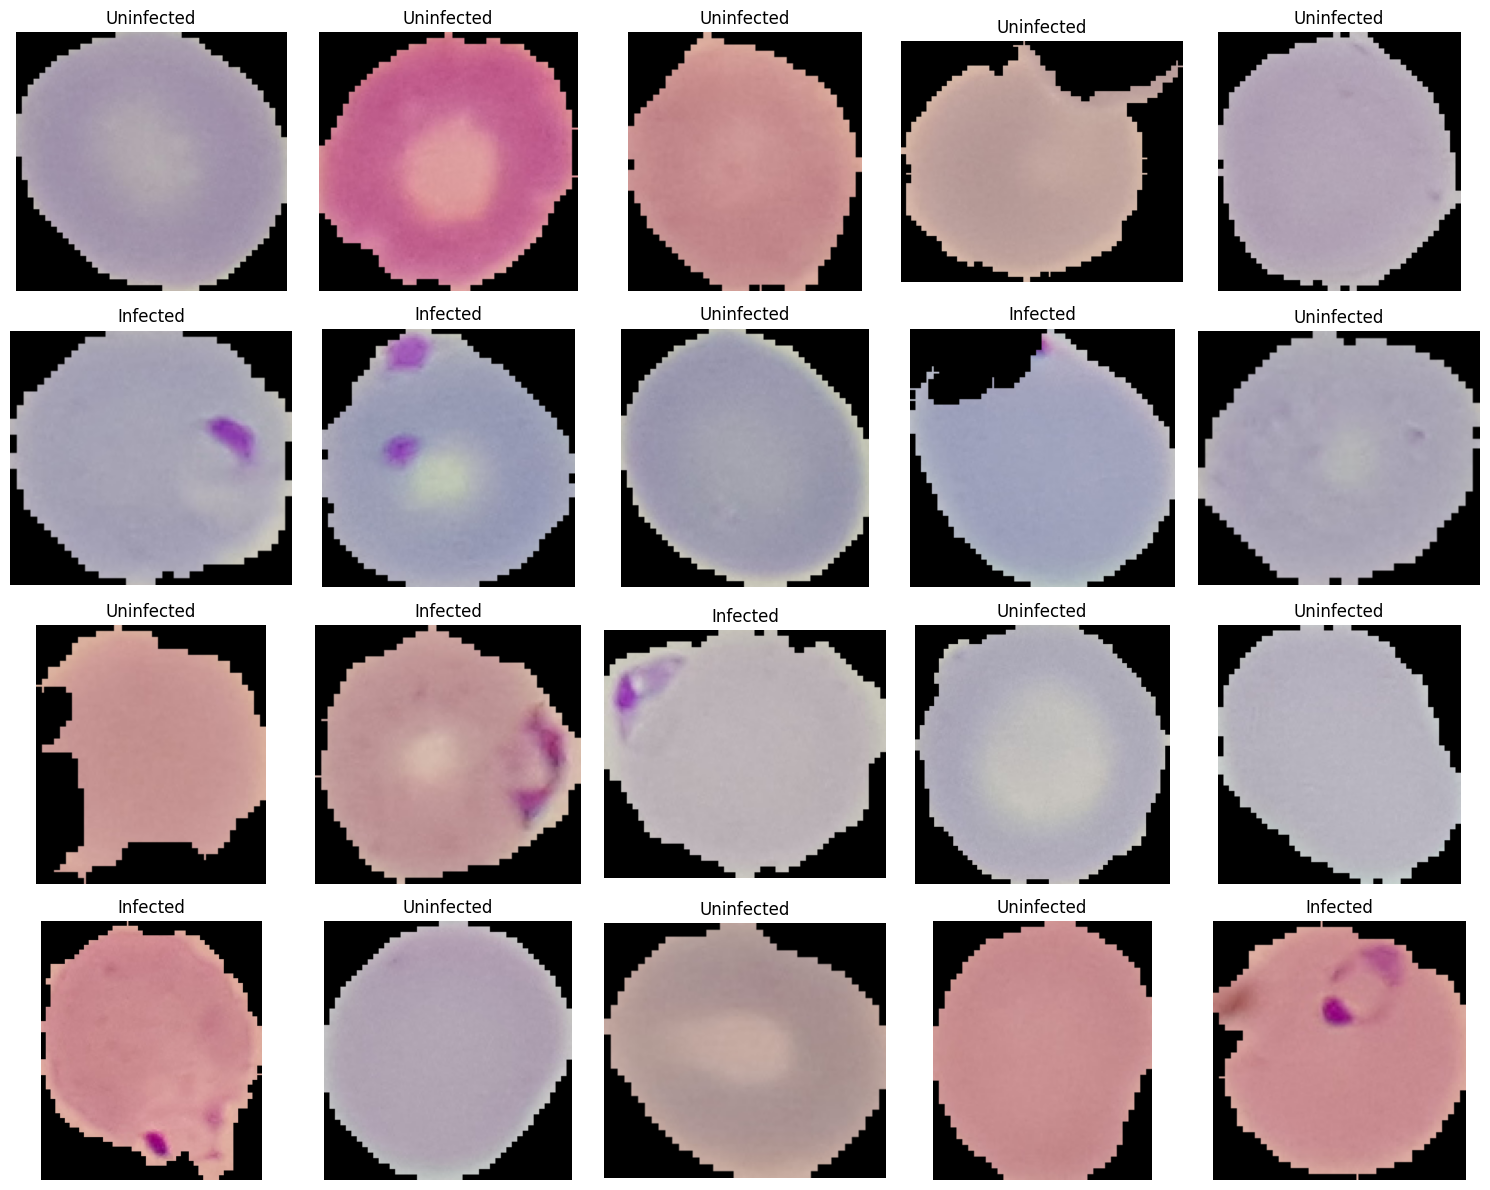

In [ ]:
def display_samples(data, nb_columns, nb_rows):
    """
    Display a grid of random samples from the dataset along with their labels.
    
    Parameters:
        data (tf.data.Dataset): The dataset to sample from.
        nb_columns (int): Number of samples per row.
        nb_rows (int): Number of samples per column.
    """
    # Prepare the figure
    plt.figure(figsize=(nb_columns * 3, nb_rows * 3))
    
    # Get random samples from the dataset
    samples = data.shuffle(1000).take(nb_columns * nb_rows)
    
    # Loop through the grid
    for idx, (image, label) in enumerate(samples):
        if idx >= nb_columns * nb_rows:
            break  # Ensure we don't exceed the grid size
        
        plt.subplot(nb_rows, nb_columns, idx + 1)
        plt.imshow(image.numpy())  # Convert TensorFlow tensor to numpy array
        plt.title("Healthy" if label.numpy() == 1 else "Infected")
        plt.axis('off')  # Remove axis for better visualization

    plt.tight_layout()
    plt.show()

# Display grid of samples from the training dataset
display_samples(train_dataset, nb_columns=5, nb_rows=4)

## Preprocessing

In [43]:
def preprocess(image, label):
        # Resize the image and normalize pixel values
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0  # Normalize to [0, 1]
        return image, label

In [44]:
# Apply preprocessing and batching
print(f"\n{YELLOW}Preprocessing and batching...{RESET}")
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE)


Preprocessing and batching...


In [45]:
# Define a CNN model
model = models.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Define the input shape explicitly
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the first MaxPooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the second MaxPooling layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout before the final dense layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [46]:
# Compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [47]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',    # Surveille la perte de validation
    patience=3,            # Arrête l’entraînement après 3 epochs sans amélioration
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

In [48]:
# Train the model
print(f"\n{YELLOW}Training model...{RESET}")
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


Training model...
Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 258s 324ms/step - accuracy: 0.6561 - loss: 0.7391 - val_accuracy: 0.9256 - val_loss: 0.2117
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 258s 326ms/step - accuracy: 0.9236 - loss: 0.2347 - val_accuracy: 0.9354 - val_loss: 0.1933
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 265s 334ms/step - accuracy: 0.9353 - loss: 0.1988 - val_accuracy: 0.9365 - val_loss: 0.1821
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 262s 330ms/step - accuracy: 0.9390 - loss: 0.1784 - val_accuracy: 0.9343 - val_loss: 0.1830
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 262s 331ms/step - accuracy: 0.9387 - loss: 0.1638 - val_accuracy: 0.9289 - val_loss: 0.1850
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 260s 328ms/step - accuracy: 0.9478 - loss: 0.1518 - val_accuracy: 0.9401 - val_loss: 0.1766
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 262s 331ms/step - accuracy: 0.9487 - loss: 0.1358 - val_accuracy: 0.9311 - val_loss: 0.1912
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 261s 329ms/step -

In [49]:
# Save the model
print(f"\n{YELLOW}Saving model to:{RESET} {MODEL_PATH}")
model.save(MODEL_PATH)


Saving model to: src/static/model/model.keras


In [50]:
# Evaluate the model on the test dataset
print(f"\n{YELLOW}Evaluating model...{RESET}")
y_true = []
y_pred = []
wrong_predictions = []

for images, labels in test_dataset:
    # Get true labels
    true_labels = labels.numpy()
    # Get predicted probabilities
    pred_probs = model.predict(images)
    # Convert probabilities to binary predictions
    pred_labels = (pred_probs > 0.5).astype(int).flatten()

    # Append results
    y_true.extend(true_labels)
    y_pred.extend(pred_labels)

    # Log wrong predictions
    for i in range(len(true_labels)):
        if true_labels[i] != pred_labels[i]:
            wrong_predictions.append({
                "True Label": true_labels[i],
                "Predicted Label": pred_labels[i],
                "Predicted Probability": pred_probs[i][0]
            })

# Convert to NumPy arrays for metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)


Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━

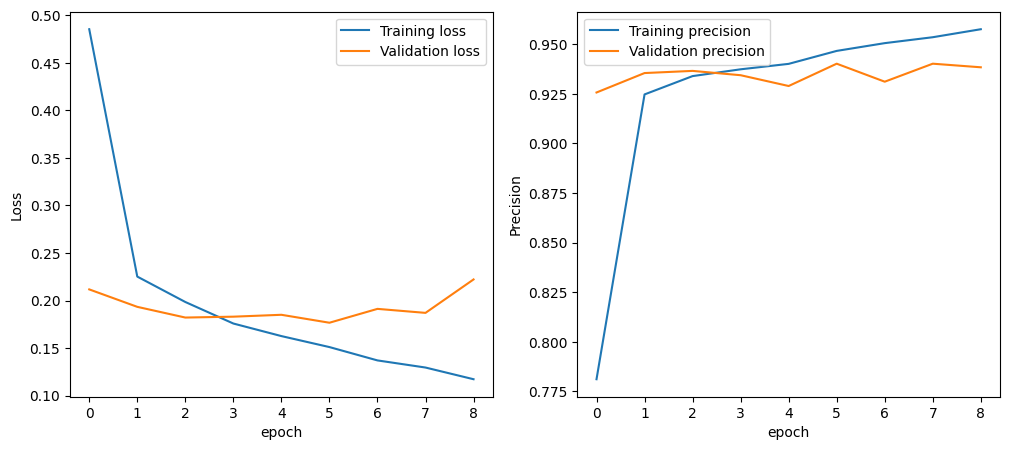

In [51]:
def plot_loss_and_precision(history):
    # Display loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Display precision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Training precision")
    plt.plot(history.history['val_accuracy'], label="Validation precision")
    plt.xlabel("epoch")
    plt.ylabel("Precision")
    plt.legend()

    plt.show()
    
plot_loss_and_precision(history)


Confusion Matrix:
[[1319   74]
 [  91 1272]]


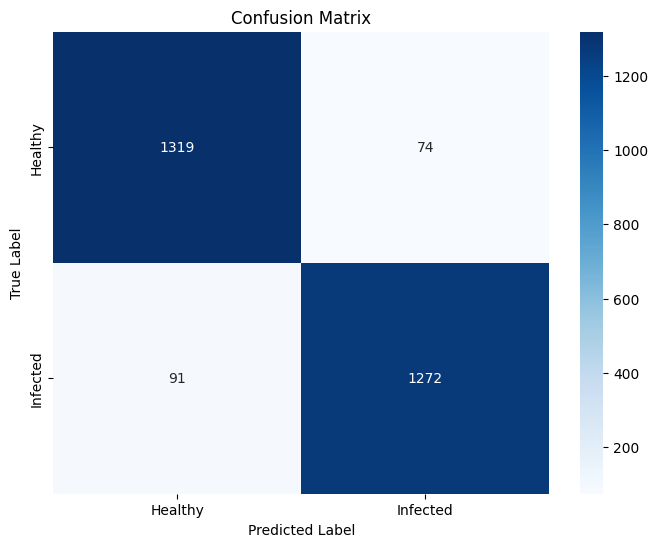

In [52]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\n{BLUE}Confusion Matrix:{RESET}")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Infected'], 
            yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
# Generate classification report
print(f"\n{BLUE}Classification Report:{RESET}")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Infected']))


Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.94      0.95      0.94      1393
    Infected       0.95      0.93      0.94      1363

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756



In [54]:
# Display wrong predictions
if wrong_predictions:
    print(f"\n{RED}Wrong Predictions:{RESET}")
    wrong_df = pd.DataFrame(wrong_predictions)
    print(wrong_df)
else:
    print(f"\n{GREEN}No wrong predictions!{RESET}")


Wrong Predictions:
     True Label  Predicted Label  Predicted Probability
0             0                1               0.612375
1             0                1               0.977004
2             1                0               0.008411
3             0                1               0.844226
4             1                0               0.001652
..          ...              ...                    ...
160           1                0               0.261396
161           1                0               0.273040
162           1                0               0.417041
163           1                0               0.367878
164           0                1               0.503031

[165 rows x 3 columns]
